# Gammapy image example

A quick example how to make a significance image of the Crab with Gammapy.

Some proper documentation will be added in the following days

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!env | grep GAMMAPY

GAMMAPY_EXTRA=/Users/deil/code/gammapy-extra


In [3]:
from gammapy.data import DataStore
ds = DataStore.from_dir('/Users/deil/code/gammapy-extra/datasets/hess-crab4/')

In [4]:
ds.info()


Data store summary info:
name: noname
base_dir: /Users/deil/code/gammapy-extra/datasets/hess-crab4
observations: 4
files: 16


In [5]:
ds.file_table

OBS_ID,TYPE,NAME,SIZE,MTIME,MD5,HDUNAME,HDUCLASS
int64,str6,str33,str1,str1,str1,str8,str8
23523,events,hess_events_simulated_023523.fits,,,,EVENTS,EVENTS
23523,aeff,hess_aeff_023523.fits.gz,,,,AEFF_2D,AEFF_2D
23523,edisp,hess_edisp_023523.fits.gz,,,,EDISP_2D,EDISP_2D
23523,psf,hess_psf_023523.fits.gz,,,,PSF_2D,PSF_2D
23526,events,hess_events_simulated_023526.fits,,,,EVENTS,EVENTS
23526,aeff,hess_aeff_023526.fits.gz,,,,AEFF_2D,AEFF_2D
23526,edisp,hess_edisp_023526.fits.gz,,,,EDISP_2D,EDISP_2D
23526,psf,hess_psf_023526.fits.gz,,,,PSF_2D,PSF_2D
23559,events,hess_events_simulated_023559.fits,,,,EVENTS,EVENTS


In [6]:
from astropy.coordinates import SkyCoord
from gammapy.image import bin_events_in_image, make_empty_image
crab = SkyCoord.from_name('crab')
ref_image = make_empty_image(nxpix=500, nypix=500, binsz=0.02,
                             xref=crab.ra.deg, yref=crab.dec.deg,
                             coordsys='CEL', proj='TAN')

In [7]:
events = ds.load(23523, 'events')
image = bin_events_in_image(events, ref_image)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


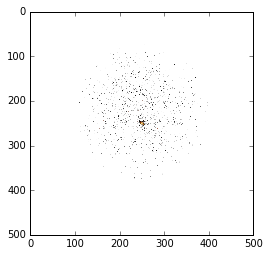

In [8]:
plt.imshow(np.log(image.data), cmap='afmhot')

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)
INFO:astropy:Auto-setting vmin to  0.000e+00
INFO:astropy:Auto-setting vmax to  1.000e+00


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.000e+00 [aplpy.core]


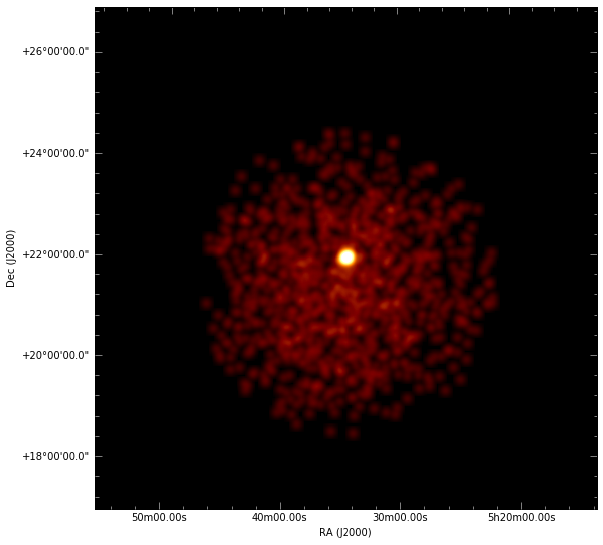

In [9]:
from aplpy import FITSFigure
fig = FITSFigure(image)
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')

In [10]:
obs_ids = [23523, 23526]
stacked_image = ref_image.copy()
for obs_id in obs_ids:
    events = ds.load(obs_id, 'events')
    run_image = bin_events_in_image(events, ref_image)
    stacked_image.data += run_image.data

INFO:astropy:Auto-setting vmin to  0.000e+00
INFO:astropy:Auto-setting vmax to  1.000e+00


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.000e+00 [aplpy.core]


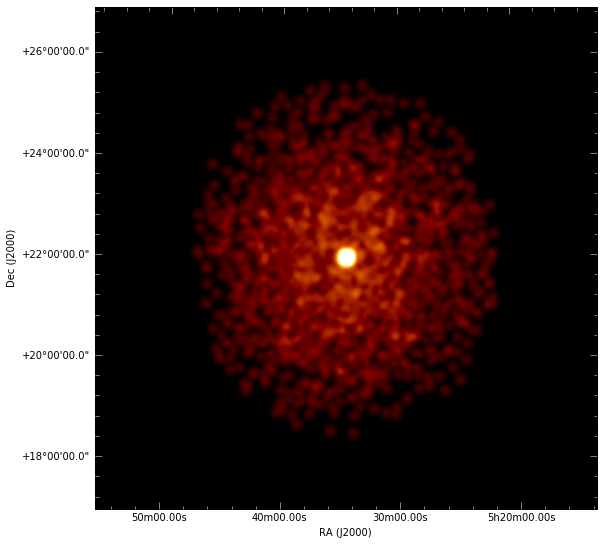

In [11]:
from aplpy import FITSFigure
fig = FITSFigure(stacked_image)
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')

In [11]:
from gammapy.image import binary_disk, binary_ring
from gammapy.background import IterativeKernelBackgroundEstimator as IKBE
from gammapy.background import GammaImages
images = GammaImages(stacked_image.data, header=stacked_image.header)
source_kernel = binary_disk(5)
background_kernel = binary_ring(20, 30)

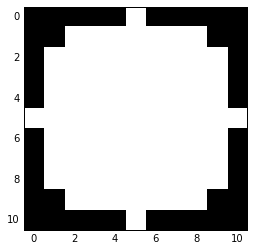

In [12]:
plt.imshow(source_kernel, interpolation='nearest', cmap='gray')

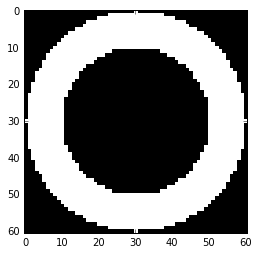

In [13]:
plt.imshow(background_kernel, interpolation='nearest', cmap='gray')

In [14]:
ikbe = IKBE(
    images=images,
    source_kernel=source_kernel,
    background_kernel=background_kernel,
    significance_threshold=5,
    mask_dilation_radius=3,
)
result = ikbe.run()

/Users/deil/code/gammapy/gammapy/stats/poisson.py:242: RuntimeWarning: invalid value encountered in true_divide
  term_b = sqrt(n_observed * log(n_observed / mu_background) - n_observed + mu_background)
/Users/deil/code/gammapy/gammapy/stats/poisson.py:242: RuntimeWarning: divide by zero encountered in log
  term_b = sqrt(n_observed * log(n_observed / mu_background) - n_observed + mu_background)
/Users/deil/code/gammapy/gammapy/stats/poisson.py:242: RuntimeWarning: invalid value encountered in multiply
  term_b = sqrt(n_observed * log(n_observed / mu_background) - n_observed + mu_background)
/Users/deil/code/gammapy/gammapy/stats/poisson.py:242: RuntimeWarning: invalid value encountered in sqrt
  term_b = sqrt(n_observed * log(n_observed / mu_background) - n_observed + mu_background)


/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)
INFO:astropy:Auto-setting vmin to  0.000e+00
INFO:astropy:Auto-setting vmax to  1.014e-01


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.014e-01 [aplpy.core]


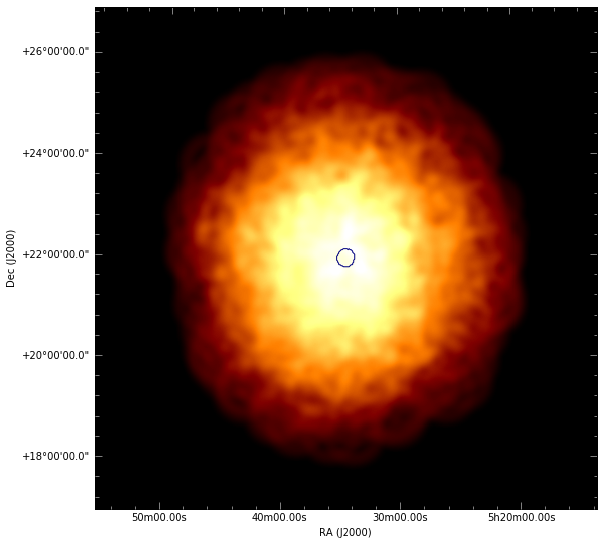

In [15]:
fig = FITSFigure(ikbe.background_image_hdu)
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')
fig.show_contour(ikbe.mask_image_hdu, levels=[0.5])

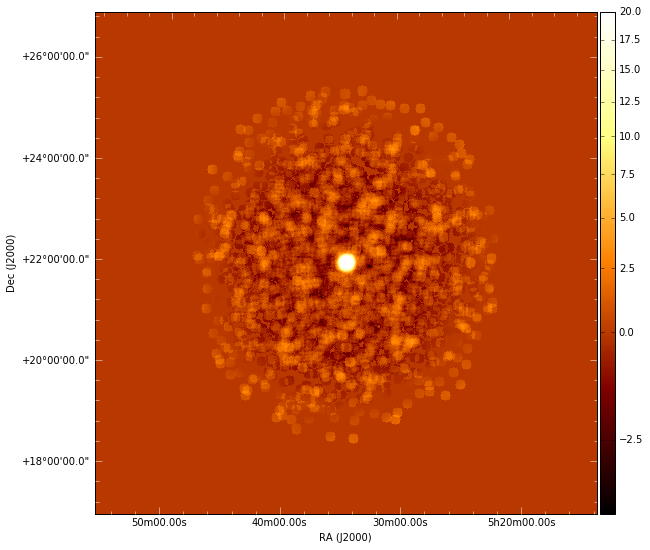

In [17]:
fig = FITSFigure(ikbe.significance_image_hdu)
fig.show_colorscale(vmin=-3, vmax=20, stretch='sqrt', cmap='afmhot')
fig.show_colorbar()

In [18]:
print('First light!')

First light!


In [19]:
print('The end.')

The end.
